
# Model training on school level data #

Here we train linear regression and XGBoost models in order to predict SAT performance from demographic data at the school level. Each model is trained and evaluated with data corresponding to one state and year. Before training each model, we do a train/test split, reserving 15% of our data for our test set. At the time of training a model, we further split our training data into training and validation sets if necessary (for instance, if we need to optimize hyperparameters).

After each model has been trained (including hyperparameter optimization), it is evaluated using the test set for the corresponding state and year, which has not been used for training or validation. We then plot, in one graph for each state, the RMSE values corresponding to each year. We also plot the RMSE values that correspond to baseline models, as a means to evaluate our models' performance.

Finally, we look at feature importance, and also test our models on the test sets.

All the functions used are defined at the bottom of the notebook.

In [106]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.base           import clone
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score



## The main model training loop ##

Here we train one model for each year, for both MA and AR (except for AR 2020, where we do not have data). Before training each model, we split our data into a training set and a test set. The test sets are stored in the dictionary `test_sets`, so that we can save them for final testing.

We store the trained models in `trained_models`. We will use them later to look at feature importance. The cross validations RMSEs for the models are stored in `results`.

The following cell takes a while to run, due mainly to the grid search used to find hyperparameters for our last XGBoost model.

In [107]:
states = ['MA', 'AR']
years  = [19, 20, 21, 22, 23]
results = []

trained_models = []
test_sets = {}
training_sets = {}

feature_names_dict = {}

for state in states:
    for year in years:
        if year == 20 and state == 'AR':
            continue
        df = load_data_and_select_cols(state, year)
        X, y = process_data(df, state)
        
        # train test split
        X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.15)
        # store test data in test_sets
        test_sets[(state, year)] = (X_test,y_test)
        training_sets[(state, year)] = (X_tr, y_tr)
        
        metrics, models = train_and_evaluate_models_cv(X_tr, y_tr, random_state = None)
        metrics.update(state = state, year = year)
        models.update(state = state, year = year)
        
        results.append(metrics)
        trained_models.append(models)
        
        feature_names_dict[(state,year)] = list(X.columns)

Here we plot the RMSEs for all the models. We make two plots, one for each state, containing the RMSEs for all models and years for that state.

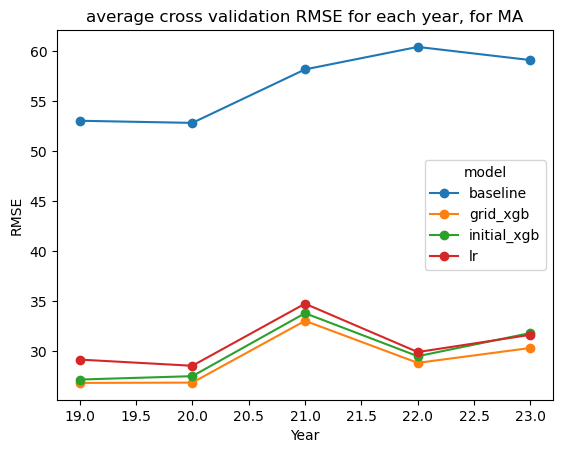

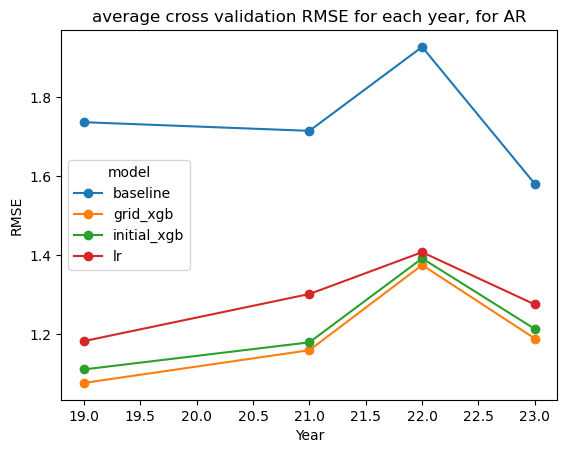

In [108]:
df_res = pd.DataFrame(results)

df_long = df_res.melt(id_vars=['year', 'state'],
                      value_vars=['rmse_baseline', 'rmse_lr', 'rmse_initial_xgb', 'rmse_grid_xgb'],
                      var_name = 'model',            
                      value_name = 'rmse')

df_long['model'] = df_long['model'].str.replace('rmse_', '')

# plot the RMSEs for the different models in the same plot, for each state
for state in df_long['state'].unique():
    # filter for this state
    sub = df_long[df_long['state'] == state]
    
    # pivot so columns are models
    pivot = sub.pivot(index = 'year', columns = 'model', values = 'rmse')
    
    # plot RMSEs for all state models in one figure
    ax = pivot.plot(marker = 'o', title = "average cross validation "f"RMSE for each year, for {state}")
    ax.set_xlabel('Year')
    ax.set_ylabel('RMSE')
    ax.legend(title = 'model')
    plt.savefig(f"rmse_plot_{state}.png", dpi=300, bbox_inches='tight')
    plt.show()

## Studying feature importance ##

In the loop above, we trained linear and XGBoost models for each state and year. We have stored the trained models in `trained_models`, and now we will look into which features are most important for these models.

### Feature importance with linear regression ###

#### coefficients heatmap ####

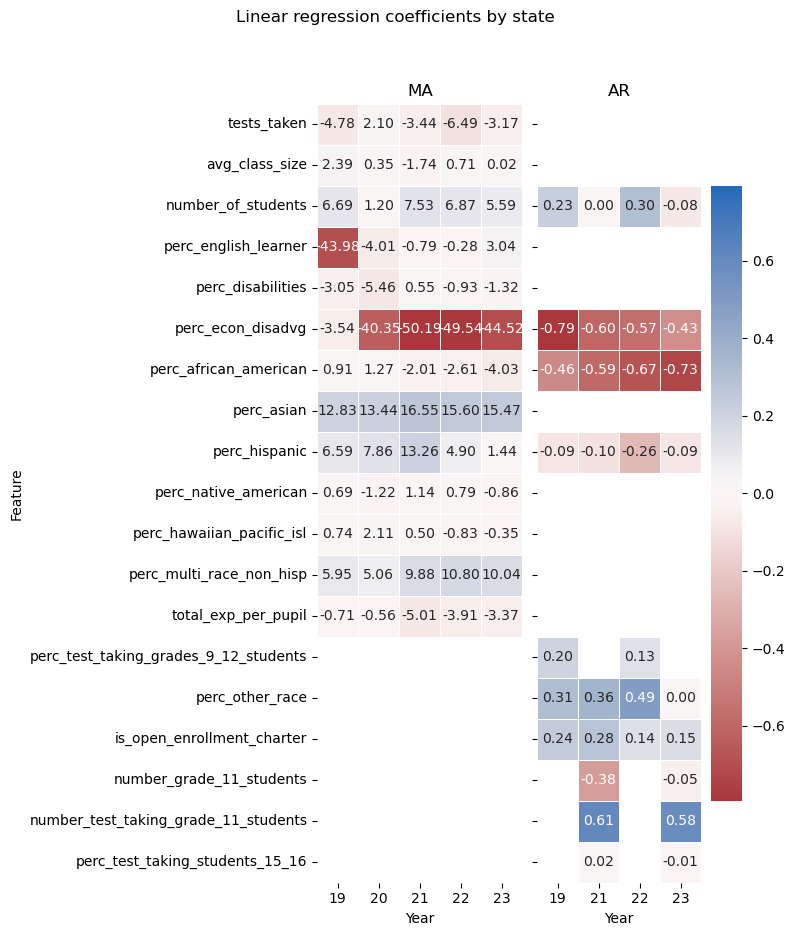

In [109]:
records = []
for rec in trained_models:
    state, year = rec['state'], rec['year']
    feature_names = feature_names_dict[(state,year)]
    
    lin = rec['lr']       
    coefs = pd.Series(lin.coef_, index=feature_names, name = (state, year))
    
    records.append(coefs)
# concat into one df: rows = features, cols = (state,year)
coef_wide = pd.concat(records, axis = 1)
coef_wide.columns = pd.MultiIndex.from_tuples(coef_wide.columns, names = ['state','year'])


states = coef_wide.columns.get_level_values('state').unique()
n_states = len(states)

fig, axes = plt.subplots(1, n_states, sharey=True, figsize = (n_states*4, coef_wide.shape[0]*0.5))

# make sure axes is iterable
if n_states == 1:
    axes = [axes]

for ax, state in zip(axes, states):
    sub = coef_wide.xs(state, axis=1, level='state')
    
    # compute per‐state color scale, ignoring NaNs
    vmax = sub.abs().max().max()

    sns.heatmap(
        sub,
        center = 0,
        cmap = 'vlag_r',
        annot = sub.round(2),
        fmt = '.2f',
        vmin = -vmax, vmax=vmax,
        linewidths = 0.5,
        cbar = (ax is axes[-1]),
        ax = ax
    )
    ax.set_title(state)
    ax.set_xlabel("Year")

axes[0].set_ylabel("Feature")
plt.suptitle("Linear regression coefficients by state")
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("linear_reg_coeffs.png", dpi=300, bbox_inches='tight')
plt.show()



### SHAP ###

Here we compute SHAP values for our XGBoost model with tuned hyperparameters. We do it for MA21 and AR21, but changing the variables `state` and `year` and selecting the correct model from trained_models one can do it for all other models. This will tell us what the most important features are for our trained XGBoost model.

First, for Arkansas 2021:

PermutationExplainer explainer: 265it [00:28,  5.94it/s]                                                               


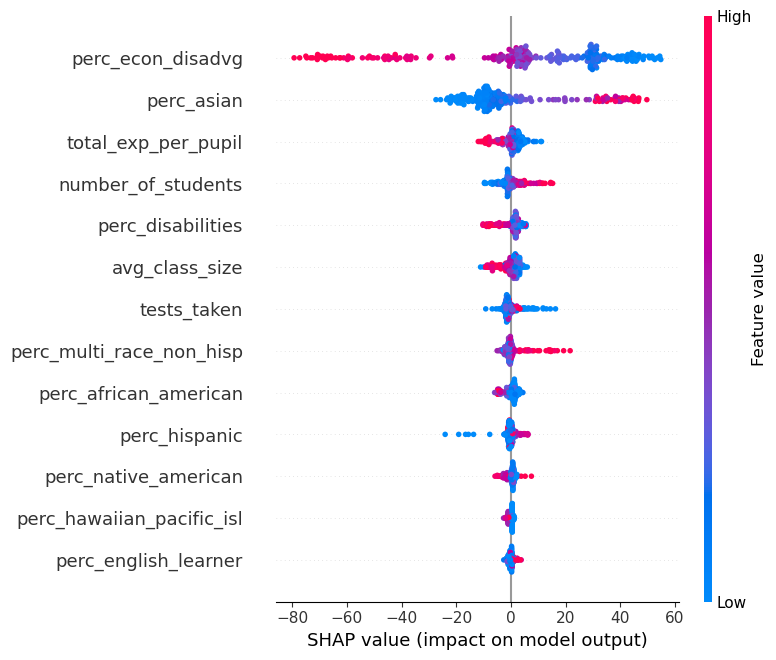

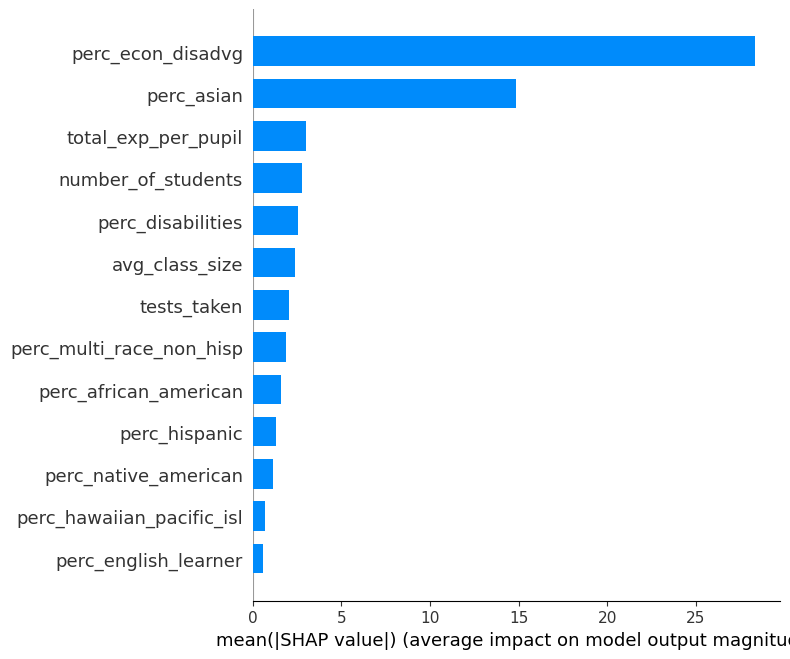

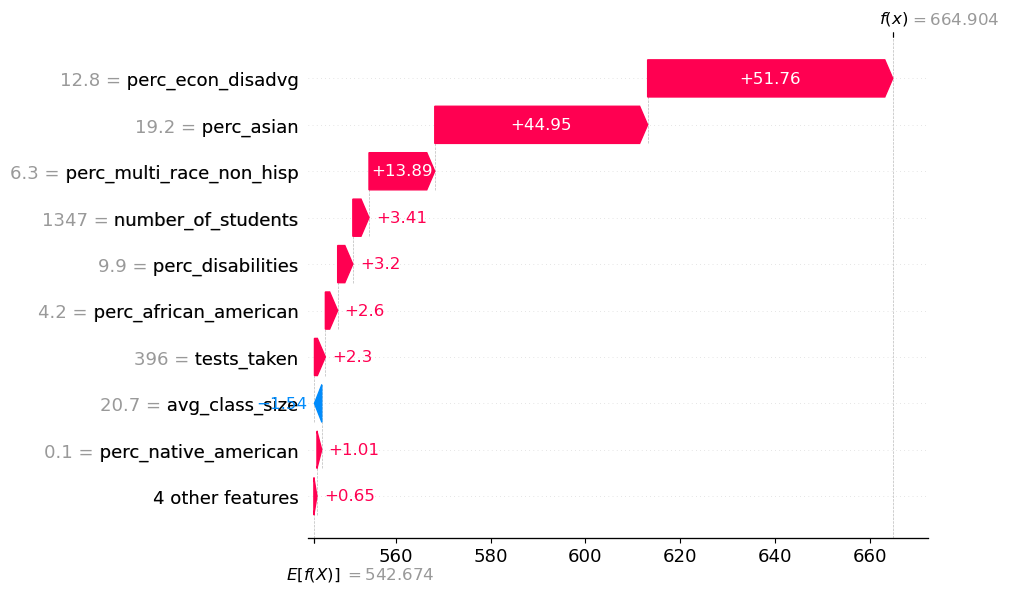

<Figure size 800x600 with 0 Axes>

In [123]:
state = 'MA'
year  = 21

X_train, y_train = training_sets[(state, year)]
model = trained_models[2]['grid_xgb']

# calculate SHAP values
explainer  = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

# plot 
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.plots.waterfall(shap_values[0])

plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.show()


Now, for Massachusetts 2021:

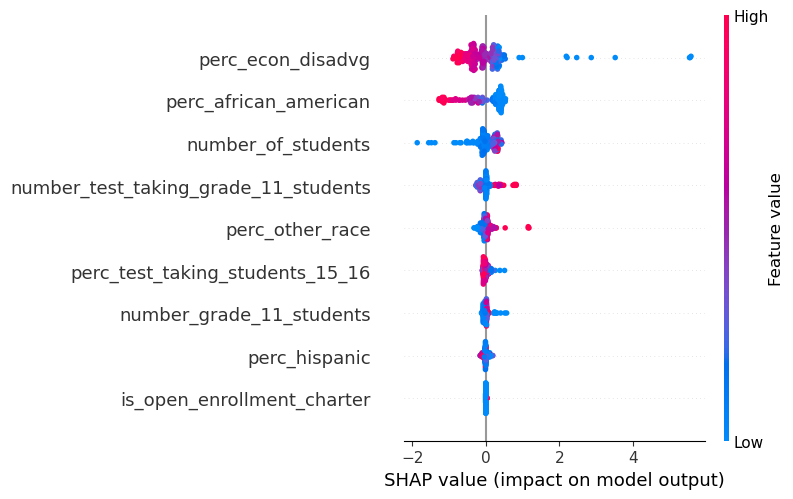

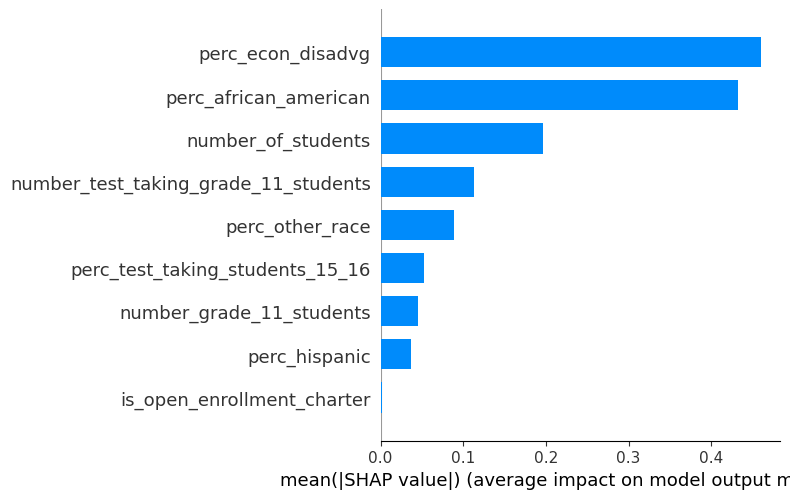

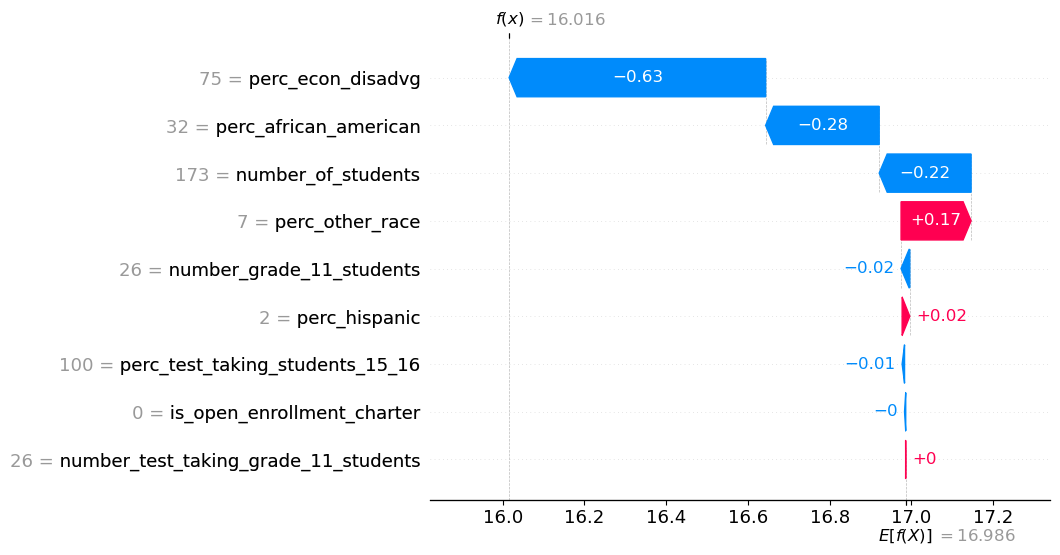

<Figure size 800x600 with 0 Axes>

In [122]:
state = 'AR'
year  = 21

X_train, y_train = training_sets[(state, year)]
model = trained_models[-3]['grid_xgb']

# calculate SHAP values
explainer  = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

# plot 
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.plots.waterfall(shap_values[0])

plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.show()



### Feature importance: conclusion ###

From what we have seen, the most important features for our models are: 
- `perc_econ_disadvg`, percentage of students who are economically disadvantaged.
- `perc_african_american`, percentage of students who are African American.
- `perc_asian`, percentage of students who are Asian.
- `number_of_students`, the number of students in the school (for MA).
- `perc_hispanic`, the percentage of students who are Hispanic (for MA).
- `perc_other_race`, the percentage of students who are not white, African American, or Hispanic (for AR). Note that this includes all Asian students.


## Final evaluation on the test sets ##

Now, we evaluate the models on the test sets stored in `test_sets`.

In [125]:
all_test_metrics = []

for rec in trained_models:
    state, year = rec['state'], rec['year']
    
    # get the corresponding test set
    X_test, y_test = test_sets[(state, year)]

    # evaluate all models on this test set
    metrics = evaluate_models_on_test_set(rec, X_test, y_test)

    # attach state and year for identification
    metrics.update(state=state, year=year)

    all_test_metrics.append(metrics)


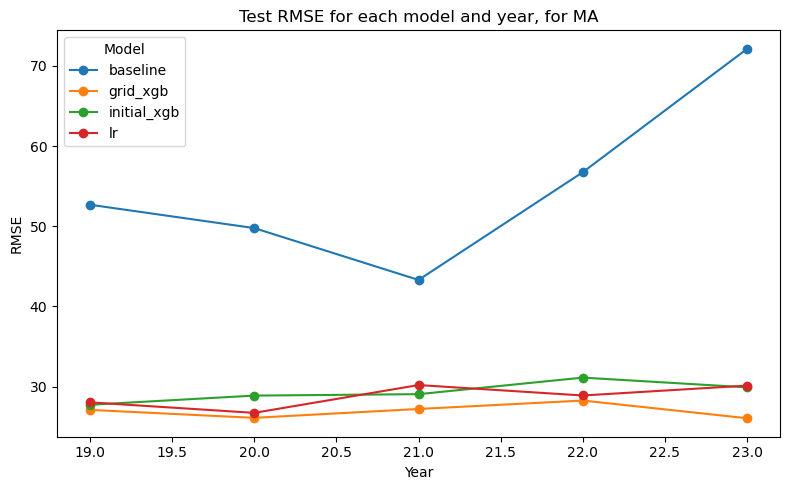

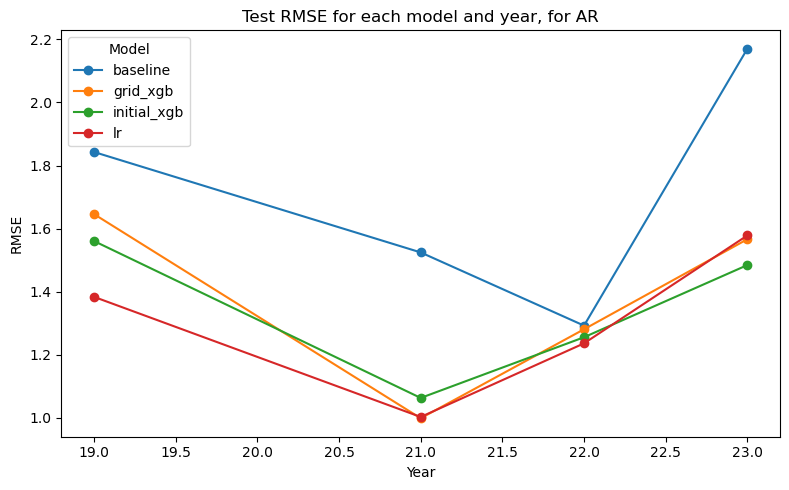

In [126]:
df_res = pd.DataFrame(all_test_metrics)

df_long = df_res.melt(id_vars = ['year', 'state'],
                      value_vars = ['rmse_baseline', 'rmse_lr', 'rmse_initial_xgb', 'rmse_grid_xgb'],
                      var_name = 'model',
                      value_name = 'rmse')

df_long['model'] = df_long['model'].str.replace('rmse_', '')

# plot the RMSEs for the different models in the same plot, for each state
for state in df_long['state'].unique():
    sub = df_long[df_long['state'] == state]
    pivot = sub.pivot(index = 'year', columns = 'model', values = 'rmse')

    ax = pivot.plot(marker = 'o',
                    title=f"Test RMSE for each model and year, for {state}",
                    figsize=(8, 5))
    ax.set_xlabel('Year')
    ax.set_ylabel('RMSE')
    ax.legend(title = 'Model')
    plt.tight_layout()
    plt.savefig(f"rmse_test_set_plot_{state}.png", dpi=300, bbox_inches='tight')
    
    plt.show()


The performance seems to be similar to the one seen in the cross-validation RMSEs.

## Auxiliary functions ##

### Producing and saving regression coefficient heatmaps ###

In [65]:
def save_statewise_lr_heatmaps(trained_models, feature_names_dict):
    # prepare data
    records = []
    for rec in trained_models:
        state, year = rec['state'], rec['year']
        feature_names = feature_names_dict[(state, year)]
        lin = rec['lr']
        coefs = pd.Series(lin.coef_, index=feature_names, name=(state, year))
        records.append(coefs)

    coef_wide = pd.concat(records, axis=1)
    coef_wide.columns = pd.MultiIndex.from_tuples(coef_wide.columns, names=['state', 'year'])

    states = coef_wide.columns.get_level_values('state').unique()

    for state in states:
        sub = coef_wide.xs(state, axis=1, level='state')

        # drop features that are all NaN for that state
        sub = sub.dropna(how='all')

        # set color scale
        vmax = sub.abs().max().max()

        # adjust plot size
        fig_width = max(6, sub.shape[1] * 1.5)
        fig_height = sub.shape[0] * 0.5 + 1
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

        sns.heatmap(
            sub,
            center = 0,
            cmap = 'vlag_r',
            annot = sub.round(2),
            fmt = '.2f',
            vmin = -vmax, vmax=vmax,
            linewidths = 0.5,
            cbar = True,
            ax = ax
        )

        ax.set_title(f"{state} - Linear Regression Coefficients")
        ax.set_xlabel("Year")
        ax.set_ylabel("Feature")
        plt.tight_layout()
        
        output_dir = os.path.join(r'C:\Users\mauro\OneDrive\Desktop\MATH\Spring_2025\Erdos\project\project_files\data', state + '_comparison')
        
        filename = os.path.join(output_dir, f"{state}_lr_coefficients.png")
        plt.savefig(filename)
        plt.close(fig)
        


In [60]:
save_statewise_lr_heatmaps(trained_models, feature_names_dict)

### The model training function ###

The function `train_and_evaluate_models` trains four models on our training data: a baseline model, a linear regression model, an XGBoost model with handpicked hyperparameters, and an XGBoost model with parameters chosen using GridSearch.
Metrics for each of these are computed using the test set, and returned in a dictionary.

In [104]:
def train_and_evaluate_models_cv(X, y, n_splits = 5, random_state = None):
    
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    metrics, models = {}, {}

    # ---------------- baseline model
    
    rmse_baseline = []
    for tr_idx, val_idx in kf.split(X):
        y_tr, y_val = (y.iloc[tr_idx], y.iloc[val_idx]) if hasattr(y, "iloc") \
                      else (y[tr_idx],    y[val_idx])
        y_hat = np.full_like(y_val, np.mean(y_tr))
        rmse_baseline.append(np.sqrt(mean_squared_error(y_val, y_hat)))
    metrics["rmse_baseline"] = np.mean(rmse_baseline)

    # ----------------- linear regression
    lr_pipe = make_pipeline(StandardScaler(), LinearRegression())
    rmse_lr = []
    # here we will store the coefficients for the model trained on each cross validation step
    fold_coefs_raw = []
    
    for tr_idx, val_idx in kf.split(X):
        # for when we use a pandas dataframe
        if hasattr(X, "iloc"):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        # for when we use a numpy array
        else:
            X_tr, X_val = X[tr_idx], X[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]

        model = clone(lr_pipe).fit(X_tr, y_tr)
        rmse_lr.append(np.sqrt(mean_squared_error(y_val, model.predict(X_val))))

        scaler = model.named_steps['standardscaler']
        # need to undo standardization so that coefficients of the different models can be averaged without getting nonsense
        beta = model.named_steps['linearregression'].coef_ / scaler.scale_
        fold_coefs_raw.append(beta)
        
    metrics["rmse_lr"] = np.mean(rmse_lr)
    
    # compute and store the average coefficients
    avg_coef = np.mean(fold_coefs_raw, axis = 0)
    models["lr_cv_avg_coef"] = avg_coef 
    
    lr_pipe.fit(X, y)
    models["lr"] = lr_pipe.named_steps["linearregression"]
    # also store the pipeline for when we evaluate on the test set at the end (since we have used StandardScaler, which scales using training data stats)
    models['lr_pipe'] = lr_pipe

    # --------------------- XGBoost
    # ----- initial XGBoost model, with improvised hyperparameters
    xgb_params = {'learning_rate' : 0.05, 'max_depth' : 2, 'n_estimators': 50, 
                  'early_stopping_rounds' : 10, 'objective' : "reg:squarederror", 'verbosity' : 0}

    xgb_template = xgb.XGBRegressor(**xgb_params)

    rmse_initial_xgb = []
    for tr_idx, val_idx in kf.split(X):
        if hasattr(X, "iloc"):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        else:
            X_tr, X_val = X[tr_idx],    X[val_idx]
            y_tr, y_val = y[tr_idx],    y[val_idx]

        model = clone(xgb_template).fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose = False)
        rmse_initial_xgb.append(np.sqrt(mean_squared_error(y_val, model.predict(X_val))))
    
    metrics["rmse_initial_xgb"] = np.mean(rmse_initial_xgb)
    models["initial_xgb"] = (clone(xgb_template).set_params(early_stopping_rounds=None).fit(X, y))

    # ----- XGBoost model using grid search for hyperparameter tuning

    # in order to ensure there are no data leaks, we do a double cross-validation: one for hyperparameter tuning (inner) 
    # and the other one for model evaluation (outer)
    
    inner_kf = KFold(n_splits = 3, shuffle=True, random_state=random_state)
    outer_kf = kf

    xgb_param_grid =  {'max_depth': [3, 5, 7],
                       'learning_rate': [0.01, 0.1, 0.2],
                       'n_estimators': [50, 100, 150, 200],
                       'subsample': [0.6, 0.8, 1.0]
                      }
    
    xgb_base = xgb.XGBRegressor(objective = "reg:squarederror", verbosity = 0)

    rmse_grid_xgb, best_params_each_fold = [], []
    
    for tr_idx, val_idx in outer_kf.split(X):
        if hasattr(X, "iloc"):               
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        else:                                
            X_tr, X_val = X[tr_idx], X[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
    
        gs = GridSearchCV(estimator = xgb_base,
                          param_grid = xgb_param_grid,
                          cv = inner_kf,
                          scoring = "neg_root_mean_squared_error",
                          n_jobs = -1,
                          refit = True
                         ).fit(X_tr, y_tr)
                    
        best_model = gs.best_estimator_
        best_params_each_fold.append(gs.best_params_)
        rmse_grid_xgb.append(np.sqrt(mean_squared_error(y_val, best_model.predict(X_val))))

    metrics["rmse_grid_xgb"] = np.mean(rmse_grid_xgb)     
    
    # refit the best model on the entire data set for later use
    final_gs = GridSearchCV(estimator = xgb_base,
                            param_grid = xgb_param_grid,
                            cv = outer_kf,         
                            scoring = "neg_root_mean_squared_error",
                            n_jobs = -1,
                            refit = True
                            ).fit(X, y)
    
    models["grid_xgb"] = final_gs.best_estimator_

    return metrics, models


In [40]:
def evaluate_models_on_test_set(models, X_test, y_test):
    metrics = {}

    # baseline
    y_pred_baseline = np.full_like(y_test, np.mean(y_test), dtype=np.float64)
    metrics["rmse_baseline"] = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
    # metrics["mae_baseline"]  = mean_absolute_error(y_test, y_pred_baseline)

    # linear regression pipeline
    if "lr_pipe" in models:
        y_pred_lr = models["lr_pipe"].predict(X_test)
        metrics["rmse_lr"] = np.sqrt(mean_squared_error(y_test, y_pred_lr))
        # metrics["mae_lr"]  = mean_absolute_error(y_test, y_pred_lr)

    # initial xgb
    if "initial_xgb" in models:
        y_pred_initial_xgb = models["initial_xgb"].predict(X_test)
        metrics["rmse_initial_xgb"] = np.sqrt(mean_squared_error(y_test, y_pred_initial_xgb))
        # metrics["mae_initial_xgb"]  = mean_absolute_error(y_test, y_pred_initial_xgb)

    # tuned xgb (grid search)
    if "grid_xgb" in models:
        y_pred_grid_xgb = models["grid_xgb"].predict(X_test)
        metrics["rmse_grid_xgb"] = np.sqrt(mean_squared_error(y_test, y_pred_grid_xgb))
        # metrics["mae_grid_xgb"]  = mean_absolute_error(y_test, y_pred_grid_xgb)

    return metrics


In [54]:
trained_models[0]

{'lr_cv_avg_coef': array([-5.50192365e-02,  1.21515822e-01,  1.55158790e-02, -2.20408213e+00,
        -1.04982393e-03, -6.39095120e-01,  1.67812995e-01,  1.80256310e+00,
         2.02274331e-01,  1.35026785e+00, -2.16591400e+00,  2.99515223e+00,
        -9.70764435e-04]),
 'lr': LinearRegression(),
 'lr_pipe': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'initial_xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
         

### Loading data and selecting columns ###

The function `load_data_and_select_cols` loads the dataframe with our data, and selects the relevant columns to be used for training models. Since data for different states contains different features, we need to deal with each state separately.

In [71]:
def load_data_and_select_cols(state, year):

    folder = os.path.join(r'C:\Users\mauro\OneDrive\Desktop\MATH\Spring_2025\Erdos\project\project_files\data', state + str(year))
    filename = state + str(year) + '_cleaned_ed_school_demographics.csv' 
    filepath = os.path.join(folder, filename)
    df = pd.read_csv(filepath)

    test_type_dict = {'AR':'ACT', 'MA' : 'SAT'}
    test_type = test_type_dict[state]
    
    drop_cols = []
    
    if state == 'AR':
        df['perc_econ_disadvg'] = df['perc_frl']
        # we drop columns which directly relate to test results: it is very likely that, e.g. science ACT results correlate highly with math ACT results.
        other_test_results = ['perc_math_readiness',
                                'perc_english_readiness', 'perc_reading_readiness',
                                'perc_science_readiness', 'perc_all_subject_readiness',
                                'ACT_english', 'ACT_reading', 'ACT_science',' Average % ACT Composite Score ',
                             'Average ACT Composite Score']
        # now we drop other features that we will not use.
        irrelevant_features = ['school_name', 'Grades', 'Grade', 'District Name','Region', 'County', 'School LEA', 
                               'DLEA', 'year',' Number of Students in Grades 9-12 ', 'Year',
                               ' % Students in grade 9-12 that took the ACT2', '% of Exams that scored 3 or Above',
                               'number_AP_exam_taking_students', 'number_AP_exams_taken'
                              ]
        
        other_drop = ['perc_white', 'perc_minority', 'perc_frl']
        drop_cols += other_test_results + irrelevant_features + other_drop
        drop_cols = [col for col in drop_cols if col in list(df.columns)]
        
    elif state == 'MA':
        # df['tests_taken_per_student'] = df['tests_taken']/df['number_of_students']
        
        other_test_results = ['SAT_reading_writing']
        irrelevant_features = ['school_name', 'School Code', 'Total # of Classes', 'Female %', 'Male %','District Code',
                               'District Name', 'In-District Expenditures','Total In-district FTEs', 'In-District Expenditures per Pupil',
                               'Total Expenditures', 'Total Pupil FTEs', 'year'
                              ]
        # cannot have all the % ethnicities as features, since they would always sum to 100
        other_drop = ['perc_white', 'perc_frl']
        drop_cols += irrelevant_features + other_test_results + other_drop
        
        drop_cols = [col for col in drop_cols if col in list(df.columns)]
        
    elif state == 'IL':
        raise NotImplementedError()

    df = df.drop(drop_cols, axis = 1)

    return df


The function `process_data` simply splits the dataframe `df` into the dataframe corresponding to features and the series representing the target variable, and returns them separately.

In [4]:
def process_data(df, state):
    test_type_dict = {'AR': 'ACT', 'MA':'SAT'}
    test_type = test_type_dict[state]
        
    y = df[test_type + "_math"]
    X = df.drop(test_type + '_math', axis = 1)

    return X, y